In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
import pandas as pd
import networkx as nx

plt.style.use('ggplot')
%matplotlib inline

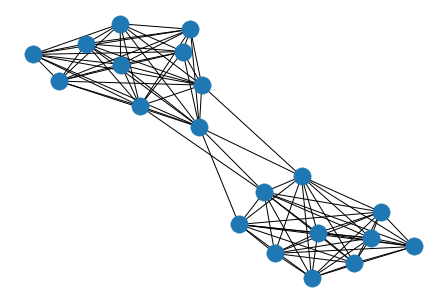

In [2]:
num_each = 20
G = nx.barbell_graph(num_each,0)

# Generate the notes with different number of edges.
mat = nx.to_numpy_array(G, dtype=int)
rate1 = 5
rate2 = 5
between = 10
mat1 = np.random.poisson(rate1, size=(num_each//2, num_each//2))
mat1 = np.tril(mat1) + np.tril(mat1,k=-1).T
mat2 = np.random.poisson(rate2,size=(num_each//2, num_each//2))
mat2 = np.tril(mat2) + np.tril(mat2, k=-1).T


mat = np.array(np.block([[mat1, np.zeros(mat1.shape, dtype=int)], [np.zeros(mat1.shape, dtype=int), mat2]]))
np.fill_diagonal(mat, 0)

mat[0,-1] = mat[-1,0] = np.random.poisson(between)
mat[0,-2] = mat[-2,0] = np.random.poisson(between)
mat[1,-2] = mat[-2,1] = np.random.poisson(between)
mat[2,-2] = mat[-2,2] = np.random.poisson(between)
mat[2,-3] = mat[-3,2] = np.random.poisson(between)

# Draw graph
G = nx.from_numpy_array(mat)
nx.draw(G)

In [3]:
model_code= """
data{
        int<lower=1> N;                    // number of nodes
        int X[N,N];                       // adjacency matrix
        int<lower=2> K;                   // number of groups
        vector[K] alpha;                  // prior for dirichlet distribution
        real a;                           // priors on lambda
        real b;                           // priors on lambda
        real c;
        real d;
} parameters {
        simplex[K] pi[N];                     // group sizes
        matrix<lower=0>[K,K] lambda; // rates between groups
} model{
        for(n in 1:N){
            pi[n] ~ dirichlet(alpha);
        }
        
        for(k in 1:K){
            for(j in 1:K)
                if(j==k){
                    lambda[k,j] ~ gamma(c,d);
                }else{
                    lambda[k,j] ~ gamma(a,b);
                }
        }
        
        for(i in 1:(N-1)){
            for(j in (i+1):N){     // assuming that X is symmetric
                X[i,j] ~ poisson(pi[i]'*lambda*pi[j]);
            }
        }

}
"""

In [4]:
sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3be6d669e276c97fe04930ee9ae1728c NOW.


In [5]:
n = num_each
k = 2
#alpha = sparse_alpha(5, k)
alpha = np.ones(2)
data = {'X' : mat, 'N' : n, 'K' : k, 'alpha' : alpha, 'a' : 7.5, 'b' : 1, 'c':5, 'd':3}
fit = sm.sampling(data=data, iter=10000, chains=1)

In [6]:
fit

Inference for Stan model: anon_model_3be6d669e276c97fe04930ee9ae1728c.
1 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=5000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
pi[1,1]        0.3  2.2e-3   0.12   0.05   0.22    0.3   0.38   0.55   2992    1.0
pi[2,1]       0.03  4.2e-4   0.03 8.2e-4 9.4e-3   0.02   0.04   0.12   5832    1.0
pi[3,1]       0.21  1.4e-3    0.1   0.03   0.14    0.2   0.27   0.41   5021    1.0
pi[4,1]       0.03  3.1e-4   0.03 5.4e-4 7.6e-3   0.02   0.04    0.1   7230    1.0
pi[5,1]       0.02  2.5e-4   0.02 5.8e-4 6.8e-3   0.02   0.03   0.08   7956    1.0
pi[6,1]       0.02  2.6e-4   0.02 5.9e-4 6.3e-3   0.02   0.03   0.09   8403    1.0
pi[7,1]       0.02  2.4e-4   0.02 5.1e-4 6.4e-3   0.01   0.03   0.08   7362    1.0
pi[8,1]       0.02  2.3e-4   0.02 5.3e-4 5.5e-3   0.01   0.03   0.07   6824    1.0
pi[9,1]       0.02  2.4e-4   0.02 5.9e-4 6.7e-3   0.02   0.03  

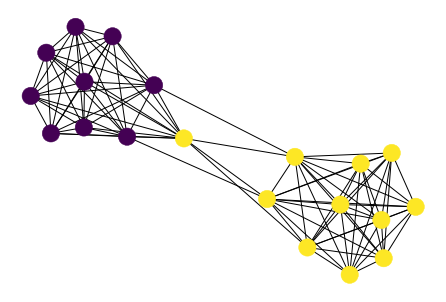

In [8]:
pi = fit.extract()["pi"]
groups = np.argmax(pi[-1],axis = 1)
nx.draw(G,node_color = groups)

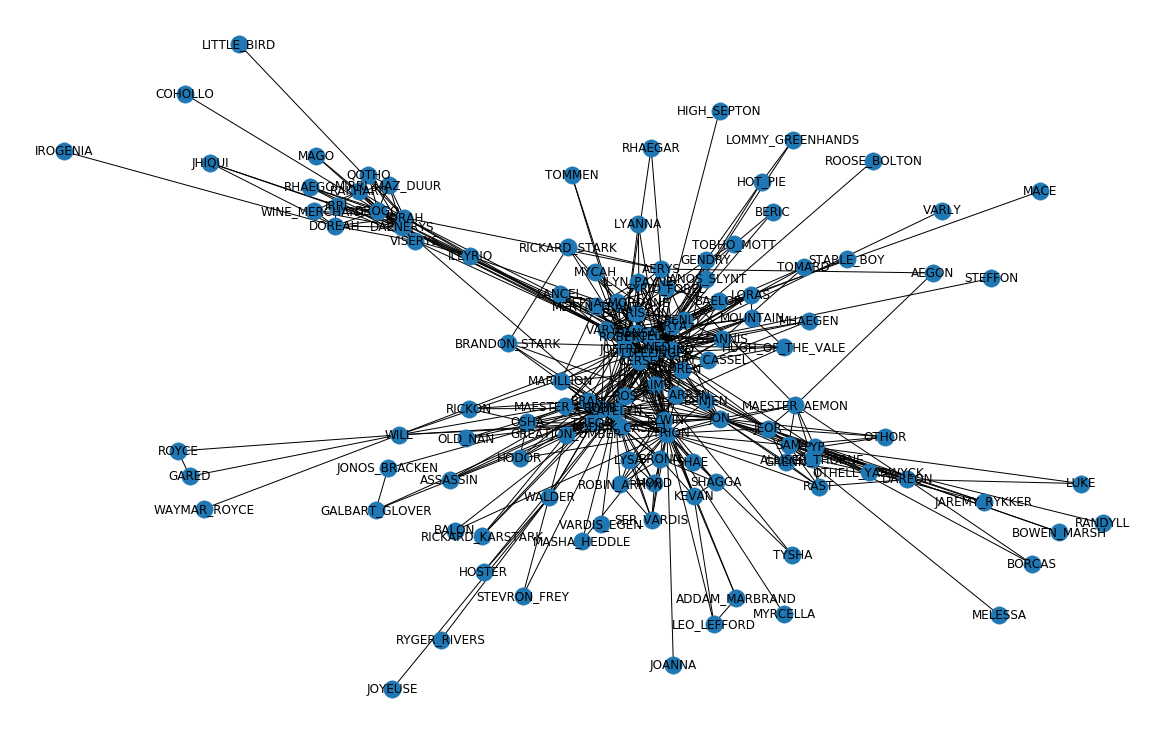

In [29]:
# load nodes and edges from file
nodes = pd.read_csv('../data/got-s1-nodes.csv')
edges = pd.read_csv('../data/got-s1-edges.csv')

# Initialize the graph based on the data from Game of Thrones Season 6
G = nx.Graph(name='Game Of Thrones S06')
G.add_nodes_from(nodes['Id'])
edge_dict = [(x['Target'],x['Source'], {'weight' : x['Weight']}) for (_,x) in edges.iterrows()]
G.add_edges_from(edge_dict)

# Conver to numpy to use with STAN
graph = nx.to_numpy_matrix(G, dtype=int)
plt.figure(figsize=(16,10))
nx.draw(G, color='r', label = nodes["Label"], with_labels=True)

In [ ]:
n = graph.shape[0]
k = 6
iterations = 1000
alpha = np.ones(k)
#alpha = sparse_alpha(5, k)
data = {'X' : graph, 'N' : n, 'K' : k, 'alpha' : alpha, 
        'a' : 0.5, 'b' :  0.1, 'c': 1,'d': 1}

In [ ]:
fit = sm.vb(data = data, iter = iterations)

In [ ]:
fit = sm.sampling(data=data, iter=iterations, chains=1)

In [31]:
pi = fit.extract()["pi"]

In [ ]:
groups = np.argmax(pi,axis = 1)

In [41]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_3be6d669e276c97fe04930ee9ae1728c.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
pi[1,1]  1.1e-3  3.9e-5 1.2e-3 1.3e-5 2.7e-4 6.7e-4 1.6e-3 4.6e-3    958    1.0
pi[2,1]  1.2e-3  3.6e-5 1.2e-3 5.1e-5 3.7e-4 9.0e-4 1.7e-3 4.1e-3   1123    1.0
pi[3,1]    0.03  1.8e-4 5.9e-3   0.02   0.03   0.03   0.04   0.04   1060    1.0
pi[4,1]  9.8e-4  2.8e-5 9.2e-4 2.8e-5 3.0e-4 7.3e-4 1.4e-3 3.4e-3   1055    1.0
pi[5,1]    0.35  8.8e-4   0.02   0.31   0.33   0.35   0.36   0.39    558    1.0
pi[6,1]  1.1e-3  4.0e-5 1.1e-3 3.2e-5 3.0e-4 7.3e-4 1.5e-3 4.4e-3    807    1.0
pi[7,1]    0.03  1.7e-4 5.2e-3   0.02   0.03   0.03   0.03   0.04    917    1.0
pi[8,1]  9.8e-4  4.3e-5 9.0e-4 3.5e-5 3.1e-4 7.3e-4 1.3e-3 3.4e-3    438    1.0
pi[9,1]    0.09  3.2e-4   0.01   0.07   0.08   0.09   

In [ ]:
plt.figure(figsize=(16,16))
nx.draw(G,node_color = groups)

In [52]:
def sparse_alpha(A, K):
    alpha = np.zeros(3*K)
    alpha[:K] = A
    
    for idx,i in enumerate(range(K,3*K)):
        alpha[i] = A*np.exp(-0.25*idx)
    
    return alpha


In [44]:
groups = fit.extract()["pi"]

In [23]:
from sklearn.metrics.cluster import adjusted_mutual_info_score

In [49]:
scores = []
for i in range(1, iterations//2):
    cluster1 = np.argmax(groups[i-4], axis = 1)
    cluster2 = np.argmax(groups[i-3], axis = 1)
    scores.append(adjusted_mutual_info_score(cluster1, cluster2))

/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


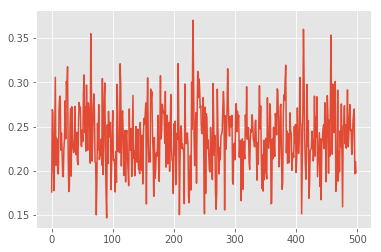

In [50]:
plt.plot(scores)

In [40]:
iterations//2

500

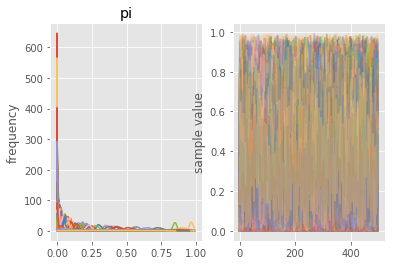

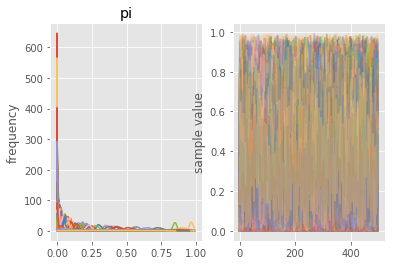

In [46]:
fit.plot("pi")